In [1]:
import pandas as pd
import numpy as np
import sys
src_path = '/Users/etiennedoidic/Desktop/DSC_180A/Infection-Risk-App/src/'
sys.path.insert(1, src_path)
import assumptions
from IPython.display import Image
import os

var = assumptions.var

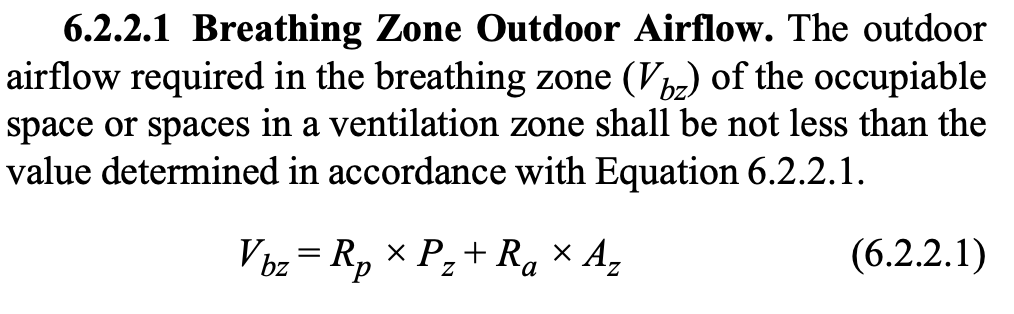

In [23]:
Image(filename='images/ashrae2.png', width=300)

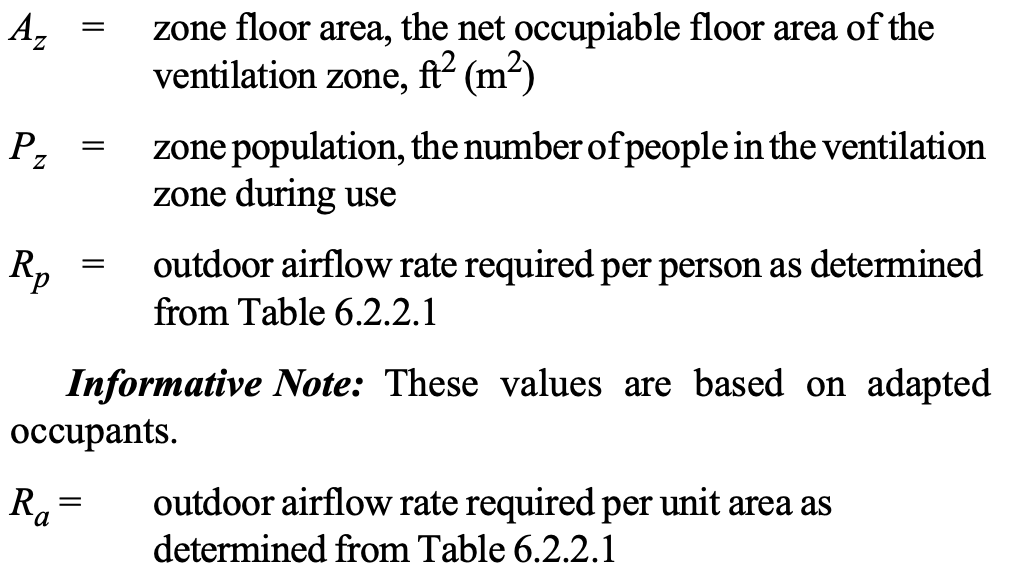

In [24]:
Image(filename='images/ashrae3.png', width=300)

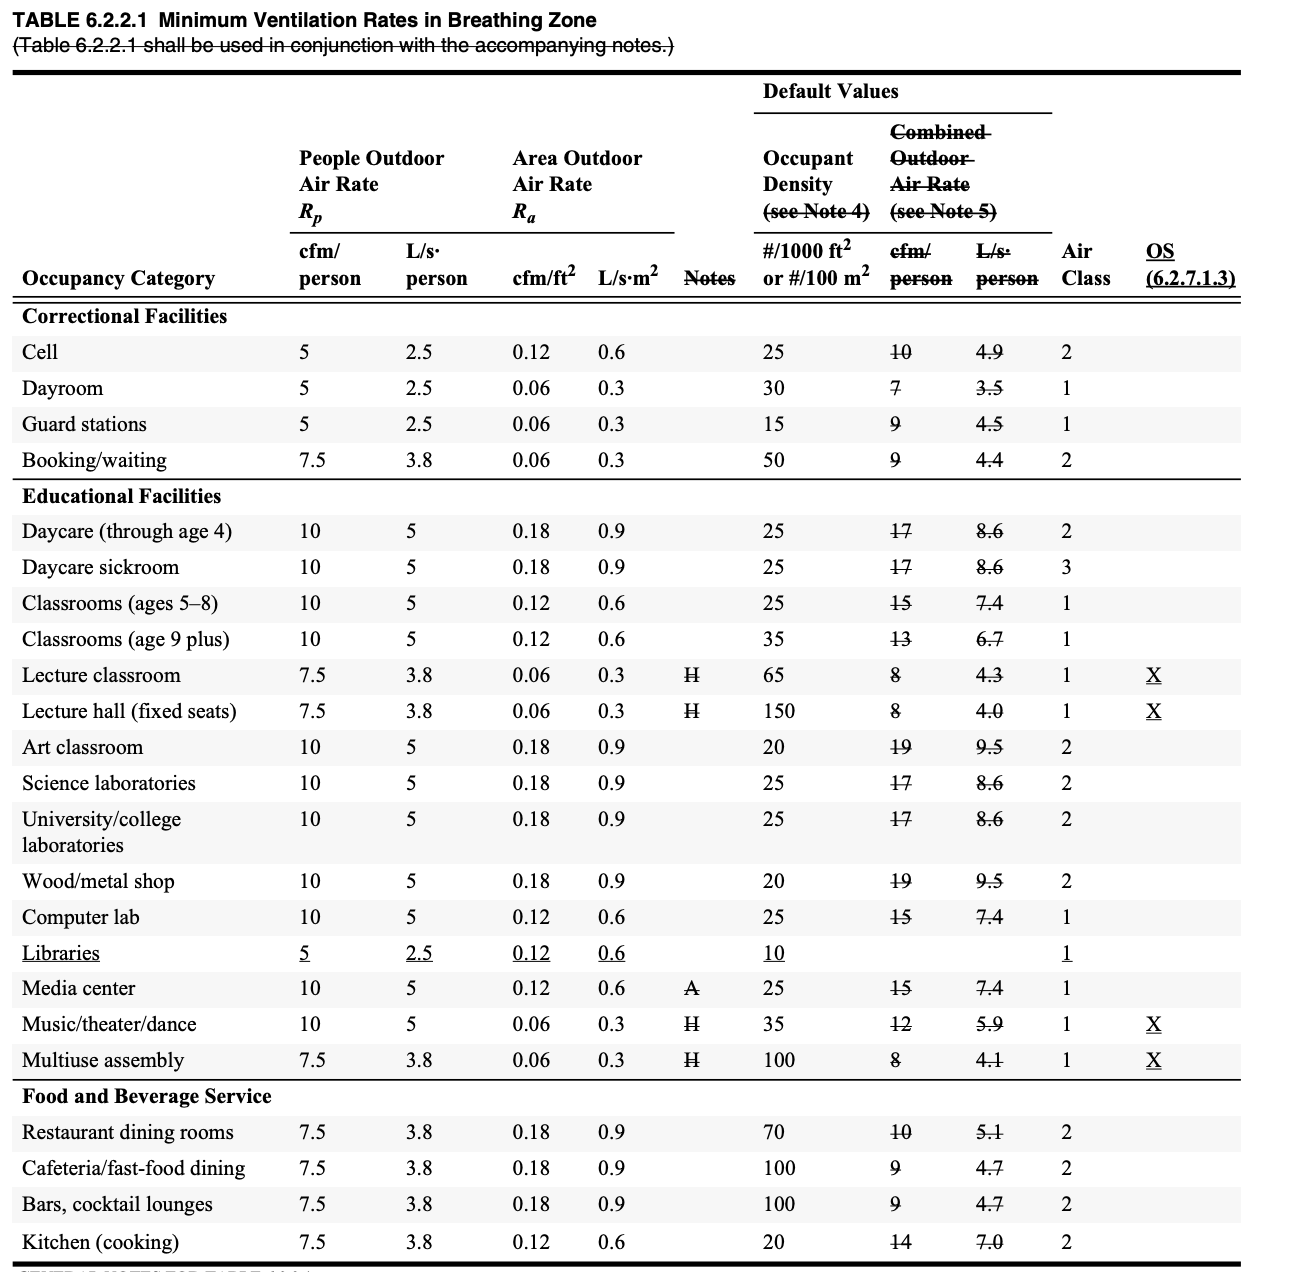

In [25]:
Image(filename='images/ashrae.png', width=500)

In [13]:
#Returns 
def extract_buildingData(bd_filepath):
    room_df = pd.read_csv(bd_filepath)
    room_df = room_df[room_df['Category'].str.match('A - Assignable Area')][['Building', 
                                                                             'Room', 
                                                                             'Area', 
                                                                             'Room Use (S)',
                                                                             'Stations']]
    exclude = ['Storage', 'Service', 'Telecomm', 'Unassigned', 'Commons', 'Unfinished', 'Altered']
    room_df = room_df[room_df['Room Use (S)'].str.contains('|'.join(exclude), regex=True) == False]
    return room_df

In [14]:
def impute_BuildingData(building_filepath):
    """
    Adds new building data to a master file 
    """
    
    occupancyImputed_TF = []
    occupancys = []
    minCFMs = []
    minVAVs = []
    maxVAVs = []
    heights = []
    building_df = extract_buildingData(building_filepath)
    for index, row in building_df.iterrows():
        building_CFM, occupancyImputed, pz = compute_CFM(row)
        minCFMs.append(building_CFM)
        occupancyImputed_TF.append(occupancyImputed)
        occupancys.append(pz)
        height = compute_height(row)
        heights.append(height)
        maxVAVs.append(-1)
        minVAVs.append(-1)
    building_df = building_df.assign(Height = heights, VAVrecommended = minCFMs, occupancyImputed_TF = occupancyImputed_TF, Occupancy = occupancys,VAVmin = minVAVs, VAVmax = maxVAVs)
    building_df = building_df[['Building', 'Room', 'Area', 'Height', 'Occupancy', 'occupancyImputed_TF', 'VAVrecommended','VAVmax', 'VAVmin']]
    building_df = building_df.drop_duplicates(subset = ['Building', 'Room'], keep = 'last').reset_index(drop = True)
    return building_df

In [15]:
def compute_CFM(row):
    """
    Compute CFM classifies the room use into a room class found in the ASHRAE ventilation standards
    In order to impute minimum airflow requirements. 
    """
    r_use = row['Room Use (S)']
    room_area = row['Area']
    occupancy = row['Stations']
    occupancyImputed = False
    #If Lecture Classroom or Lecture Hall
    if r_use in ['110 - Classroom (S)', 
                 '270 - Open Laboratory (N)',
                 '270 - Open Lab - Restricted (N)',
                 '340 - Conference Room (S)',
                 '470 - Tutorial / Training Room (N)']:
        #if large enough classify as lecture hall
        if room_area > 500:
            CFM, occupancyImputed, pz = reqCFM_calculator('lectureHall', occupancy, room_area)
       #else lecture classroom
        else:
            CFM, occupancyImputed, pz = reqCFM_calculator('lectureClassroom', occupancy, room_area) 
    #If Office space
    elif r_use in ['211 - Research Office - Enclosed (S)',
                 '335 - Office Service (S)',
                 '460 - Library Processing Room (N)',
                 '320 - Administrative Office - Enclosed (S)', 
                 '211 - Research Office - Open (S)',
                 '310 - Academic Office - Enclosed (S)',
                 '226 - Research Office Service (S)',
                 '320 - Administrative Office - Open (S)',
                 '340 - Conference Room (S)',
                 '250 - Scholarly Activity (S)',
                 '410 - Study Room (N)',
                 '440 - Stack (N)']:
        CFM, occupancyImputed, pz = reqCFM_calculator('officeSpace', occupancy, room_area) 
    #if Research Lab
    elif r_use in ['225 - Research Lab / Studio Service (S)',
                 '210 - Research Laboratory / Studio (S)',
                  '260 - Class Laboratory (S)',
                  '711 - Shop - Teaching Laboratory (S)',
                  '580 - Animal Quarters (N)']:
        CFM, occupancyImputed, pz = reqCFM_calculator('collegeLaboratories', occupancy, room_area) 
   #if media room 
    elif r_use in ['560 - Media Production (S)']:
        CFM, occupancyImputed, pz = reqCFM_calculator('mediaCenter', occupancy, room_area) 
    #if Shop
    elif r_use in ['710 - Shop - General and Research (S)',
                   '261 - Special Class Laboratory (S)']:
        CFM, occupancyImputed, pz = reqCFM_calculator('woodMetalShop', occupancy, room_area)
    #If multiuse assembly, (e.g. art gallery,)
    elif r_use in ['660 - Exhibit (N)',
                   '650 - Assembly (N)']:
        CFM, occupancyImputed, pz = reqCFM_calculator('multiuseAssembly', occupancy, room_area)
    #If library
    elif r_use in ['430 - Combined Stack / Study Room (N)']:
        CFM, occupancyImputed, pz = reqCFM_calculator('libraries', occupancy, room_area)
    #If Kitchen
    elif r_use in ['610 - Food Facility (N)',
                   '335 - Office - Kitchenette/break room (S)']:
        CFM, occupancyImputed, pz = reqCFM_calculator('kitchen', occupancy, room_area)
    elif r_use in ['520 - Athletics (N)',
                   '640 - Merchandising (N)']:
        CFM, occupancyImputed, pz = reqCFM_calculator('gym', occupancy, room_area)
    else:
        print('New Classification Required:')
        print(r_use)
        print(row['Building'])
    try:
        CFM
    except NameError:
        print('Error for room ' + ' ' + str(row['Room']))
    else:
        return CFM, occupancyImputed, pz

In [16]:
def compute_height(row):
    #TODOOOOOO
    return 10

In [17]:
def reqCFM_calculator(rclass, Pz, Az ,var = var):
    """"
    Returns the minimum required airflow in cubic feet per minute (CFM) based on room class,
    occupancy and area, Given ANSI/ASHRAE Standards
    url: https://www.ashrae.org/File%20Library/Technical%20Resources/Standards%20and%20Guidelines/Standards%20Addenda/62.1-2016/62_1_2016_s_20190726.pdf
    Formula: Ventilation = Rp * Pz + Ra * Az
    Az == Floor area in sq ft
    Pz == Zone occupancy or zone population 
    Rp == Outdoor Airflow rate in cfm / person 
    Ra == Outdoor Airflow rate in cfm /sq ft  
    Od == Occupant Density. occ/1000 sq ft"""
    af_standards = var['ASHRAE_table']
    occupancyImputed = False
    Od_CONVERSION = 1000
    if Pz == 0:
        Pz = Az / Od_CONVERSION * af_standards[rclass]['Od']
        occupancyImputed = True
    Rp = af_standards[rclass]['Rp']
    Ra = af_standards[rclass]['Ra']
    CFM = Rp * Pz + Ra * Az
    return CFM, occupancyImputed, Pz

In [18]:
directory = '/Users/etiennedoidic/Desktop/DSC_180A/Infection-Risk-App/notebooks/fm_building_data'
master_directory = '/Users/etiennedoidic/Desktop/DSC_180A/Infection-Risk-App/data/masterBuildingData.csv'
#Randomly select file to build masterBuildingData.csv off of
master_df = impute_BuildingData(directory + '/' + 'MANDERooms.csv')
master_df.reset_index(drop = True)
master_df.to_csv(master_directory)


In [19]:
i = 0
for filepath in os.listdir(directory):
    if filepath.endswith('.csv'):
        if i == 0:
            master_df = impute_BuildingData(directory + '/' + filepath)
            master_df.reset_index(drop = True)
            master_df.to_csv(master_directory)
        else:
            master_df = pd.read_csv(master_directory).drop(['Unnamed: 0'], axis= 1)
            curr_df = impute_BuildingData(directory + '/' + filepath)
            master_df = master_df.append(curr_df)
            master_df.to_csv(master_directory)
        i = 1
    else:
        print('Error: ')
        print("This file is not a .csv")
master_df = pd.read_csv(master_directory).drop(['Unnamed: 0'], axis= 1)
for building in master_df['Building'].unique():
    print(building)

Error: 
This file is not a .csv
Error: 
This file is not a .csv
Fred N. Spiess Hall
Galbraith Hall
Conrad Prebys Music Center
Che Cafe
Ritter Hall
Geisel Library
York Hall
Urey Hall
Molli and Arthur Wagner Dance Building
RIMAC
Biology Building
Peterson Hall
Mandeville Center
Solis Hall
Literature Building
Warren Lecture Hall
Computer Science and Engineering Building
Center Hall
Applied Physics and Mathematics


##### 

In [20]:
master_df.loc[master_df.duplicated(subset=['Building', 'Room'])]

,Building,Room,Area,Height,Occupancy,occupancyImputed_TF,VAVrecommended,VAVmax,VAVmin
